# WGAN prac

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision import datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### Generator

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        )

    def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        result = self.gen(x)
        return result

## Critic

In [11]:
class Critic(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.crit_block(im_chan, hidden_dim),
            self.crit_block(hidden_dim, hidden_dim*2),
            self.crit_block(hidden_dim*2, 1, final_layer=True)
        )

    def crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

### noise

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### hyper parameters setting

In [5]:
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 2e-4

beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

### Data loading

In [6]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size = batch_size,
    shuffle = True
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Optimizer

In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## gradient

In [13]:
def get_gradient(crit, real, fake, epsilon):
    #Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    return gradient

In [14]:
def gradient_penalty(gradient):
    # Flatten te gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

## loss

In [15]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [16]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    # crit_loss = torch.mean(crit_real_pred) - torch.mean(crit_fake_pred) + c_lambda * gp
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

## Image Display

In [17]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Training

In [20]:
n_epochs = 50
cur_step = 0
generator_losses = []
critic_losses = []

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        gen_opt.step()

        generator_losses += [gen_loss.item()]

        # Visualize the results
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"step {cur_step}: Generator loss : {gen_mean}, Critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="generator loss"
            )

            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic loss"
            )

            plt.legend()
            plt.show()
            
        cur_step += 1

Output hidden; open in https://colab.research.google.com to view.

# celeba prac

### import

In [31]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision import datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)

### hyper parameters

In [32]:
n_epochs = 50
display_step = 500
lr = 2e-4

# Spatial size of training images, images are resized to this size.
image_size = 64
batch_size = 128

beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

workers = 2 # Number of workers for dataloader
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

### data loading

In [22]:
from torchvision import datasets
# Root directory for the dataset
data_root = "data/celeba"

# Data load
celeba_dataset = datasets.CelebA(data_root,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                       std=[0.5, 0.5, 0.5])
                              ]))



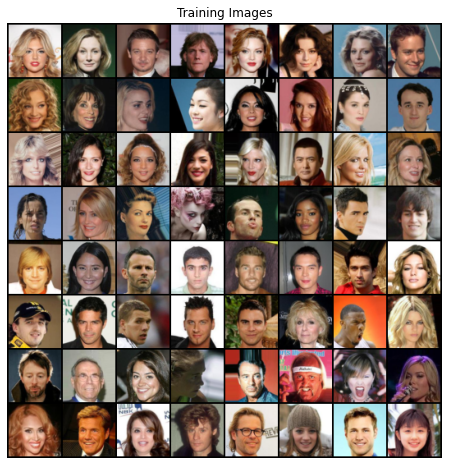

In [29]:
import torchvision.utils as vutils

# Create the dataloader
dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                         batch_size=batch_size,
                                         num_workers=workers,
                                         shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Generator

In [47]:
class Generator(nn.Module):
    def __init__(self, nz=100, nc=3, ngf=64):
        super(Generator, self).__init__()
        self.nz = nz
        # Build the neural network
        self.gen = nn.Sequential(
            # # input is Z, going into a convolution
            self.gen_block(nz, ngf*8, padding=0),
            # state size. (ngf*8) x 4 x 4
            self.gen_block(ngf*8, ngf*4),
            # state size. (ngf*4) x 8 x 8
            self.gen_block(ngf*4, ngf*2),
            # state size. (ngf*2) x 16 x 16
            self.gen_block(ngf*2, ngf),
            # state size. (ngf) x 32 x 32
            self.gen_block(ngf, nc, final_layer=True)
            # state size. (nc) x 64 x 64
        )

    def gen_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                nn.Tanh()
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.nz, 1, 1)
        result = self.gen(x)
        return result

### Critic

In [48]:
class Critic(nn.Module):
    def __init__(self, nc=3, ngf=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.crit_block(nc, ngf),
            self.crit_block(ngf, ngf*2),
            self.crit_block(ngf*2, ngf*4),
            # self.crit_block(ngf*4, ngf*8),
            self.crit_block(ngf*4, 1, final_layer=True)
        )

    def crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, bias=False, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=bias),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=bias)
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

### Optimizer

In [49]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

### gradient

In [50]:
def get_gradient(crit, real, fake, epsilon):
    #Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    return gradient

In [51]:
def gradient_penalty(gradient):
    # Flatten te gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

### loss

In [52]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [53]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    # crit_loss = torch.mean(crit_real_pred) - torch.mean(crit_fake_pred) + c_lambda * gp
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

### image display func

In [54]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Training

step 500: Generator loss : -0.353395532249473, Critic loss: 0.5000517690910027


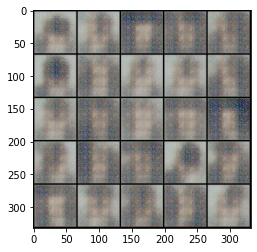

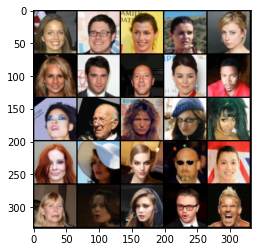

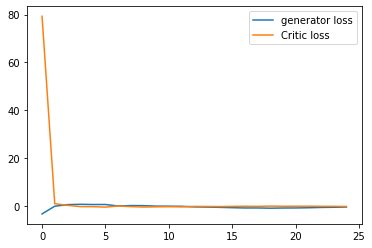

step 1000: Generator loss : -0.3716888252794743, Critic loss: -0.2143225811719895


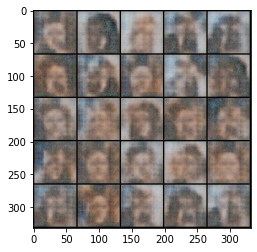

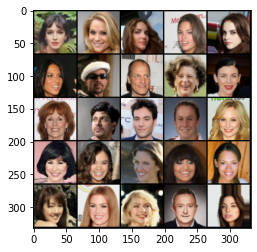

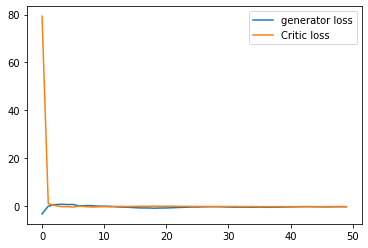

KeyboardInterrupt: ignored

In [55]:
n_epochs = 3
cur_step = 0
generator_losses = []
critic_losses = []

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        gen_opt.step()

        generator_losses += [gen_loss.item()]

        # Visualize the results
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"step {cur_step}: Generator loss : {gen_mean}, Critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="generator loss"
            )

            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic loss"
            )

            plt.legend()
            plt.show()
            
        cur_step += 1